In [1]:
import pandas as pd
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.io import read_image
from torchvision import transforms
from torch import nn
import matplotlib.pyplot as plt
import torch
import numpy as np
from PIL import Image

# Dataset

In [43]:
from torchvision import datasets
from torchvision.transforms import ToTensor

preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

preprocess2 = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_data = datasets.GTSRB(
    root='data',
    download=True,
    split='train',
    transform=preprocess2
)
test_data = datasets.GTSRB(
    root='data',
    download=True,
    split='test',
    transform=preprocess2
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


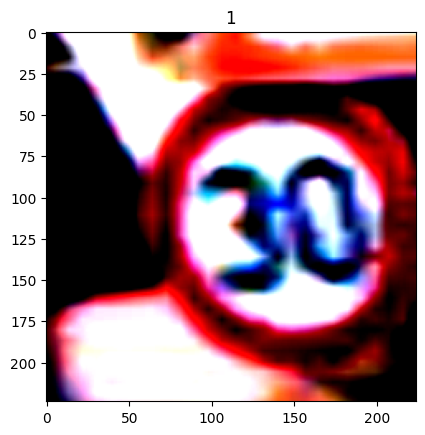

In [44]:
import matplotlib.pyplot as plt
plt.imshow(train_data[1000][0].permute(1, 2, 0))
plt.title('%i' % train_data[1000][1])
plt.show()

In [45]:
train_data, val_data = torch.utils.data.random_split(train_data, [1000, len(train_data) - 1000])
test_data, val_data = torch.utils.data.random_split(test_data, [100, len(test_data) - 100])

In [62]:
distribution = {}
distribution_test = {}
for data in train_data:
    if data[1] in distribution:
        distribution[data[1]] += 1
    else:
        distribution[data[1]] = 1

for data in test_data:
    if data[1] in distribution_test:
        distribution_test[data[1]] += 1
    else:
        distribution_test[data[1]] = 1

In [46]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=4, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=4, 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7fa495329280>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7fa495329c10>}

# Model

In [47]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
# device = "cpu"
print(f"Using {device} device")

Using cuda device


In [48]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
model.fc = nn.Linear(512, 43)
model.to(device)
print(model)

Using cache found in /home/diler/.cache/torch/hub/pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Train

In [20]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [21]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss = loss.item()
            print(f"loss: {loss:>7f}")

In [22]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [49]:
epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}")
    train(loaders['train'], model, loss_fn, optimizer)
    test(loaders['test'], model, loss_fn)
print("Done!")

Epoch 1
loss: 4.840742
loss: 4.268092
loss: 3.984540
Test Error: 
 Accuracy: 3.0%, Avg loss: 3.876051 

Epoch 2
loss: 3.642942
loss: 4.196651
loss: 4.617618
Test Error: 
 Accuracy: 3.0%, Avg loss: 3.859659 

Epoch 3
loss: 4.113690
loss: 3.807956
loss: 4.042781
Test Error: 
 Accuracy: 3.0%, Avg loss: 3.889898 

Epoch 4
loss: 4.112771
loss: 3.932030
loss: 3.402738
Test Error: 
 Accuracy: 2.0%, Avg loss: 3.918650 

Epoch 5
loss: 4.219573
loss: 4.226200
loss: 3.997096
Test Error: 
 Accuracy: 3.0%, Avg loss: 3.879005 

Epoch 6
loss: 3.965984
loss: 3.450768
loss: 3.756274
Test Error: 
 Accuracy: 1.0%, Avg loss: 3.927972 

Epoch 7
loss: 3.577153
loss: 3.845165
loss: 3.555583
Test Error: 
 Accuracy: 2.0%, Avg loss: 3.875376 

Epoch 8
loss: 4.377530
loss: 4.739528
loss: 4.235827
Test Error: 
 Accuracy: 2.0%, Avg loss: 3.901357 

Epoch 9
loss: 4.100989
loss: 3.757535
loss: 4.113629
Test Error: 
 Accuracy: 1.0%, Avg loss: 3.967845 

Epoch 10
loss: 3.778999
loss: 4.269869
loss: 3.991844
Test Error

KeyboardInterrupt: 

# Test

In [73]:
model.eval()

predicted = []
true = []
with torch.no_grad():
    for X, y in loaders['test']:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        predicted.extend(pred.argmax(1).tolist())
        true.extend(y.tolist())


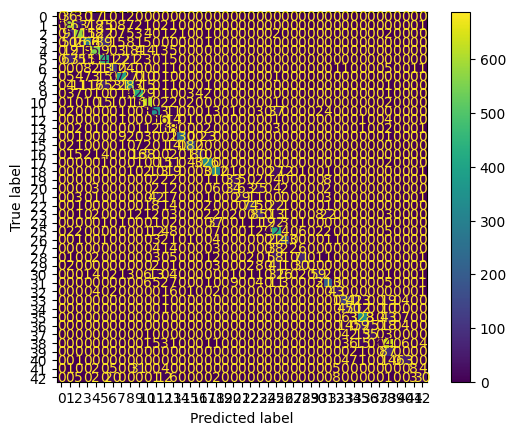

In [75]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

confusion_matrix(true, predicted)
ConfusionMatrixDisplay(confusion_matrix(true, predicted)).plot()

In [76]:
accuracy_score(true, predicted)

0.7568487727632621